In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
import json

In [2]:
from utils.image import Image
from utils.region import Region, get_spaced_colors, generate_label_map

In [3]:
ANNOTATION_FOLDER = "ann"
IMAGE_FOLDER = "img"

In [22]:
from unet.model import UNet
import torch
model = UNet(in_channels=1, pretrained=False)
model.load_state_dict(torch.load("best_model.h5", map_location="cpu"))
model.eval();

In [23]:

def find_regions(info):
    objects = info['objects']
    regions = []
    for region in objects:
        class_splited = region['classTitle'].split("/")
        category = class_splited[0]
        subcategory = class_splited[1]
        countour = region['points']['exterior']
        regions.append(Region(category, subcategory, np.array(countour, int)))
    return regions


def parse_json(file):
    _dirname = os.path.dirname(os.path.dirname(file))
    basename = os.path.basename(file)
    image_filename = os.path.splitext(basename)[0]
    image_path = os.path.join(_dirname, IMAGE_FOLDER, image_filename)

    image = cv2.imread(image_path)
    image_object = Image(image, filename=image_filename)

    with open(file) as f:
        info = json.load(f)
        image_object.regions = find_regions(info)
    return image_object


[0.00612053 0.00619094 0.00632781 ... 0.99991465 0.9999207  0.9999211 ]


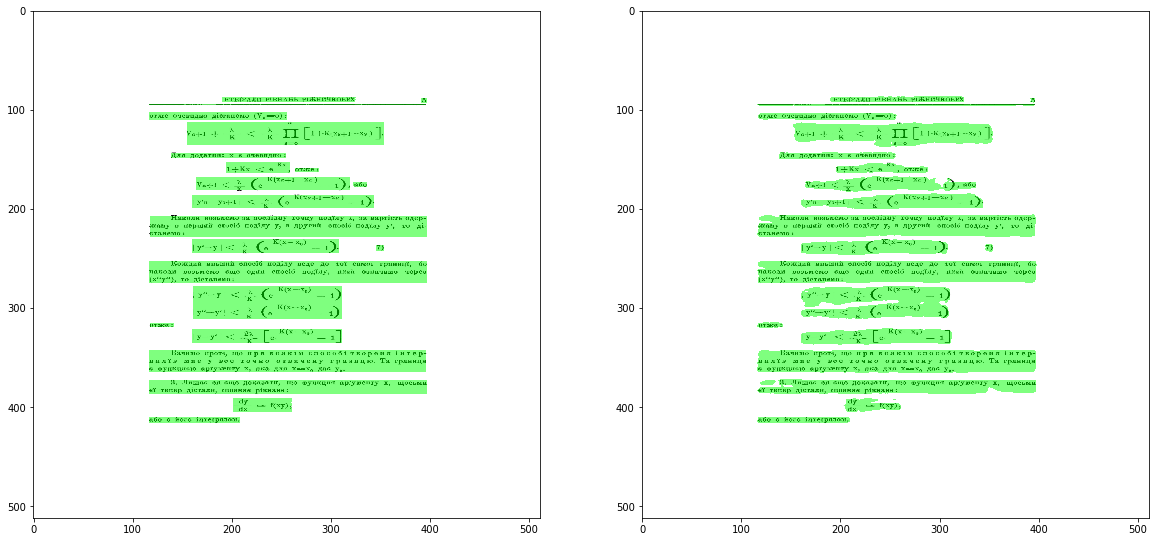

[0.00356979 0.00360924 0.00362774 ... 0.99999464 0.9999949  0.999995  ]


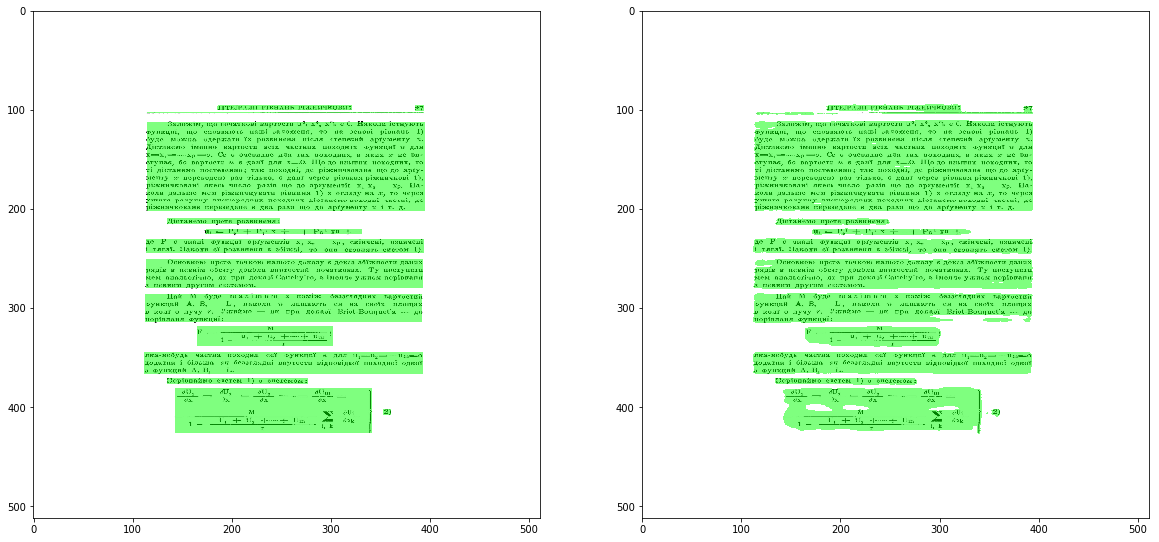

[0.00520783 0.00549236 0.00563421 ... 0.9999627  0.9999664  0.99997187]


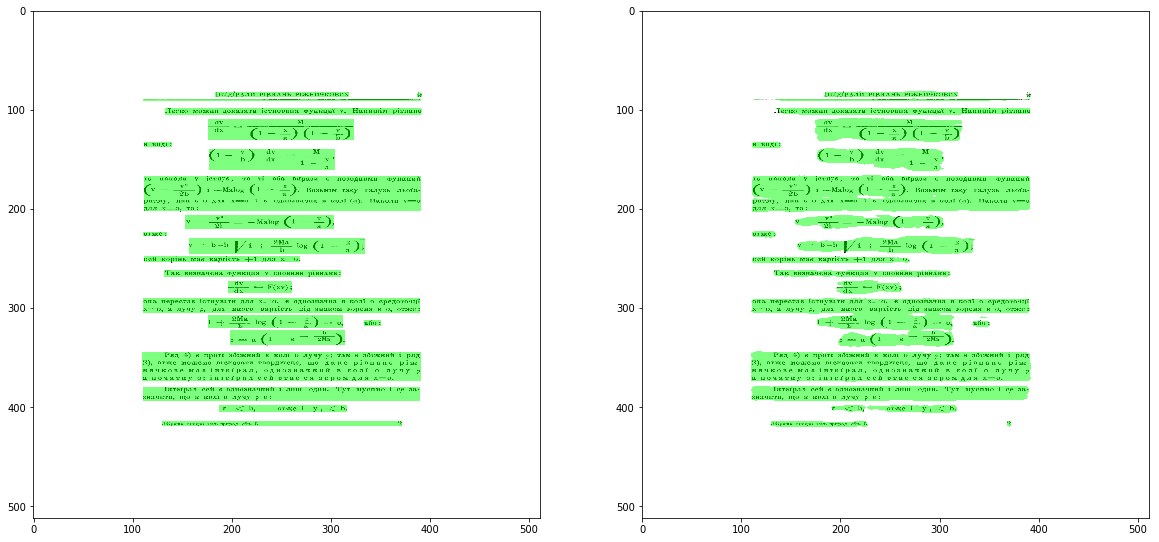

[0.0050124  0.00529275 0.0055278  ... 0.99988544 0.9999063  0.99990726]


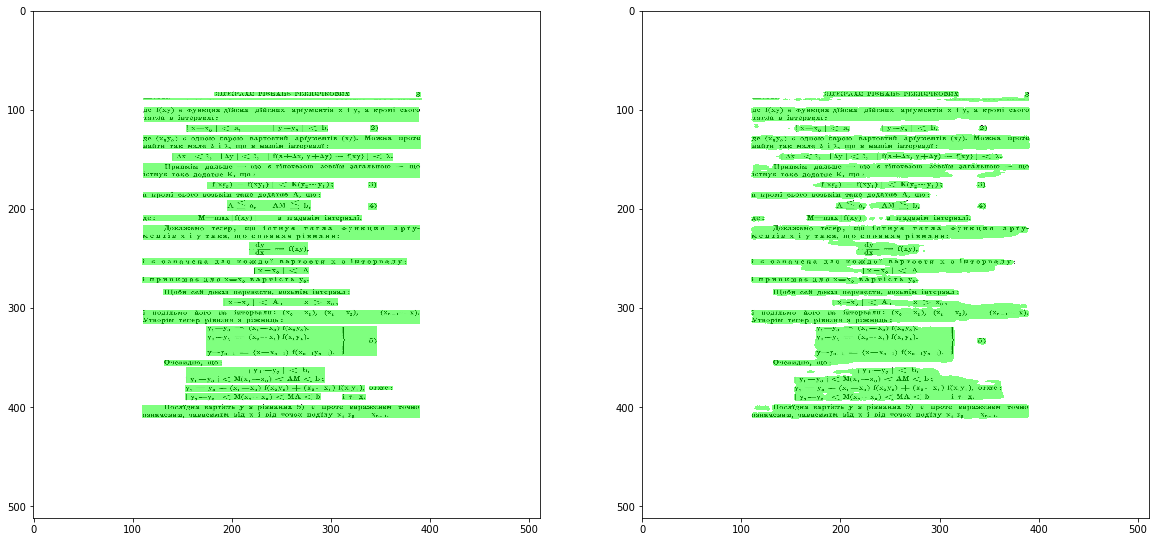

[0.00388056 0.00390103 0.00412385 ... 0.99985063 0.9998591  0.99986374]


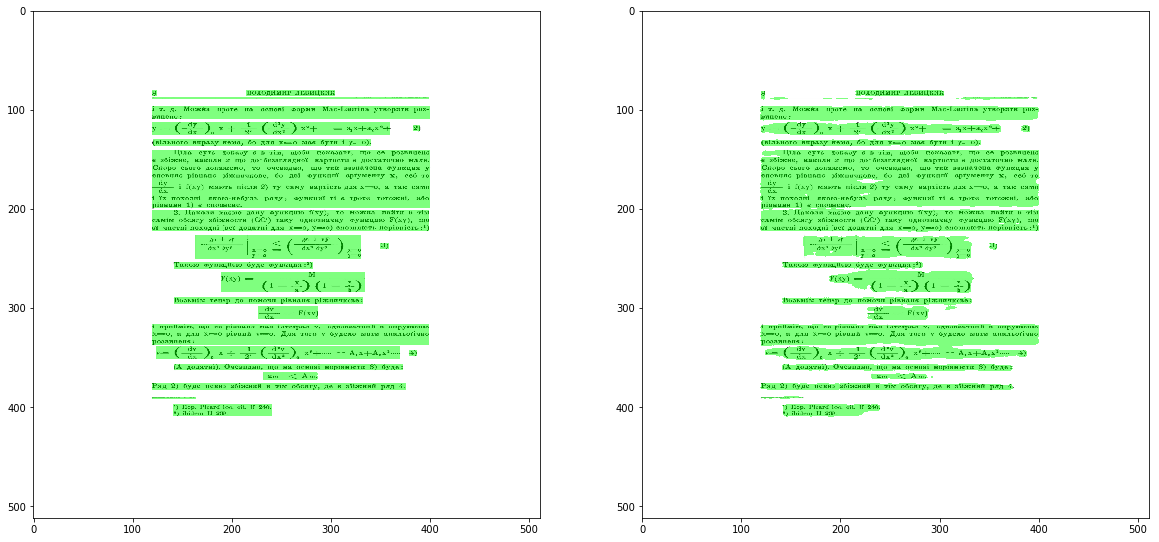

[0.00543389 0.0055317  0.00613004 ... 0.9999033  0.9999063  0.9999074 ]


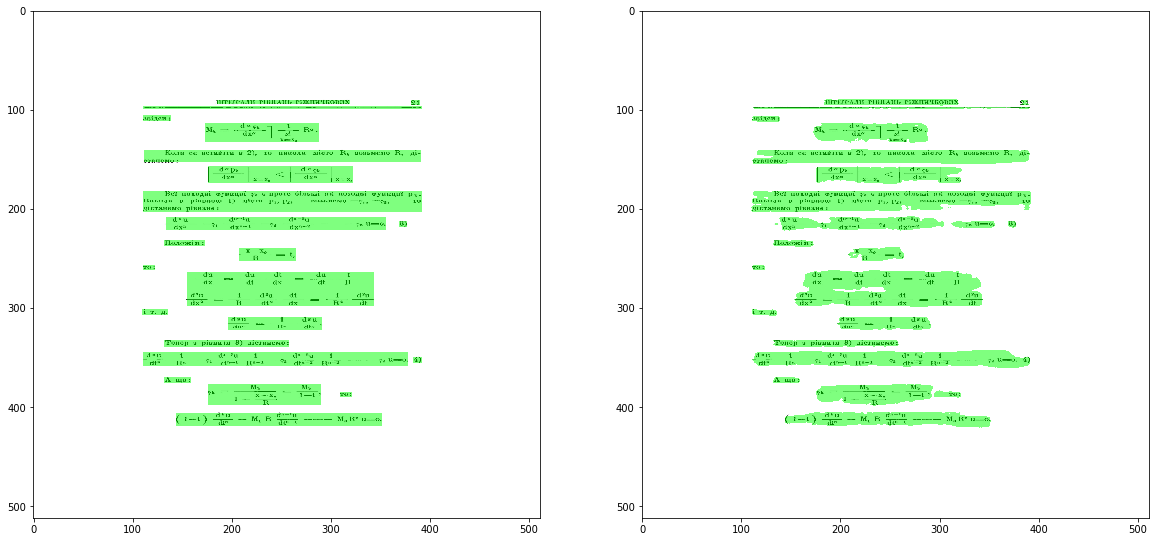

[0.00467771 0.00489504 0.00512181 ... 0.9999932  0.9999938  0.9999943 ]


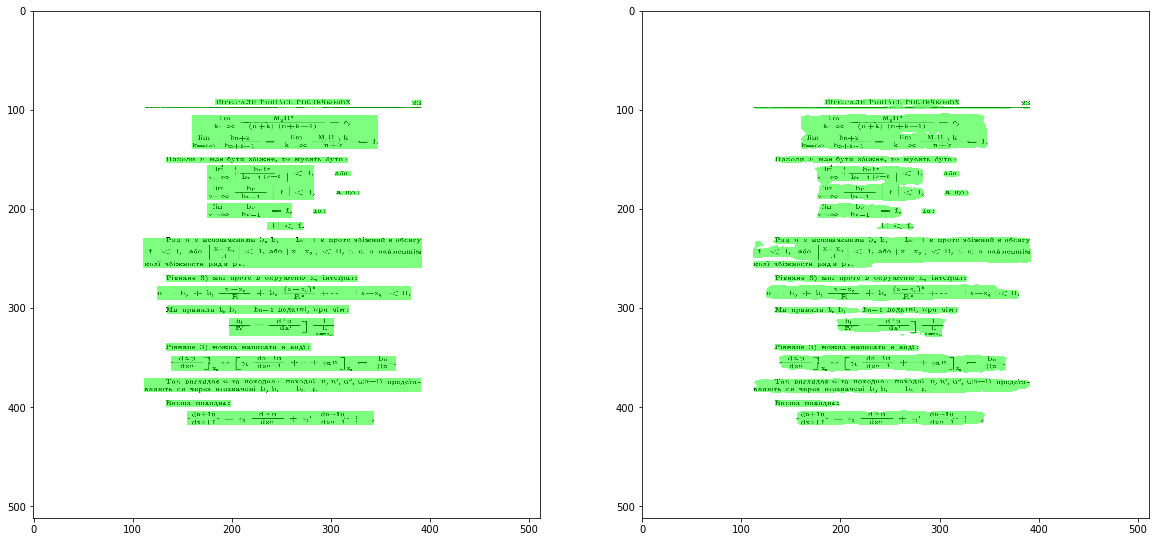

[0.00483311 0.00534211 0.0053899  ... 0.9999796  0.9999833  0.9999857 ]


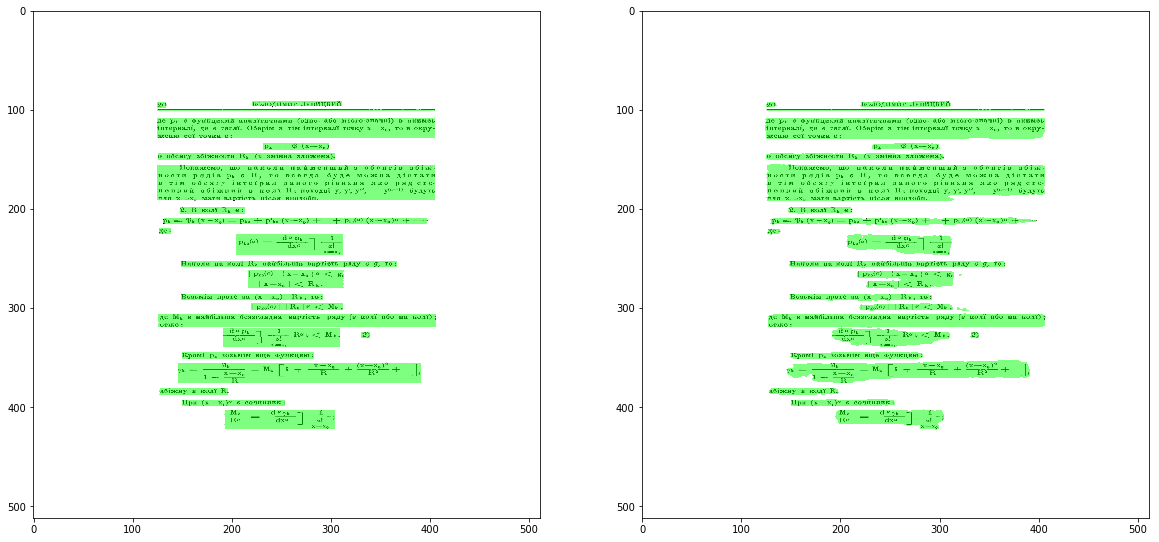

[0.00491764 0.00527342 0.00529545 ... 0.999897   0.9998971  0.99990714]


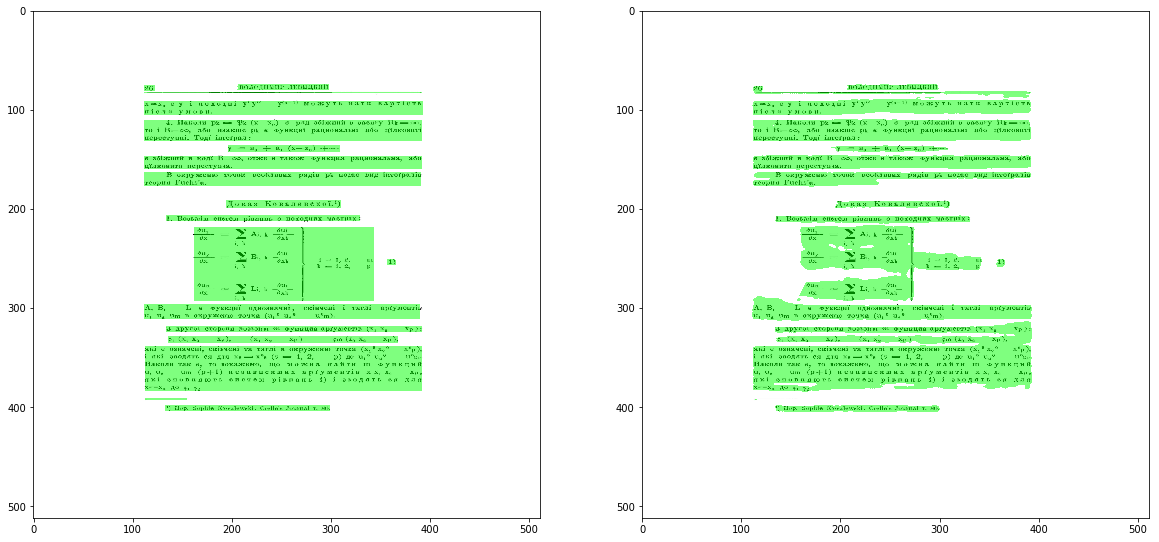

[0.00563187 0.00596221 0.00598165 ... 0.99999046 0.9999912  0.999992  ]


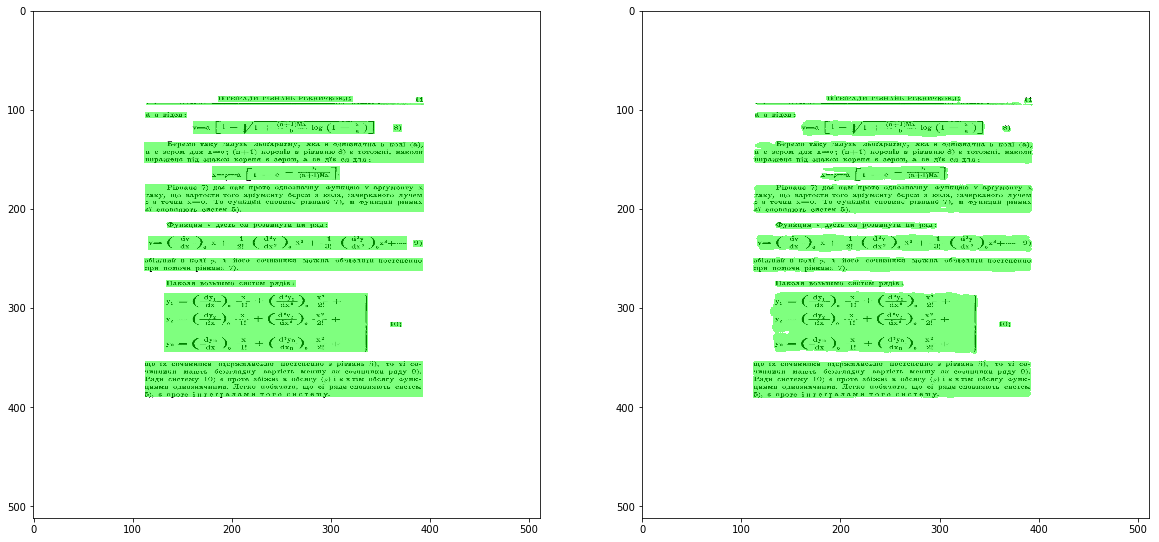

[0.00598115 0.00600261 0.00637172 ... 0.9999639  0.9999715  0.9999732 ]


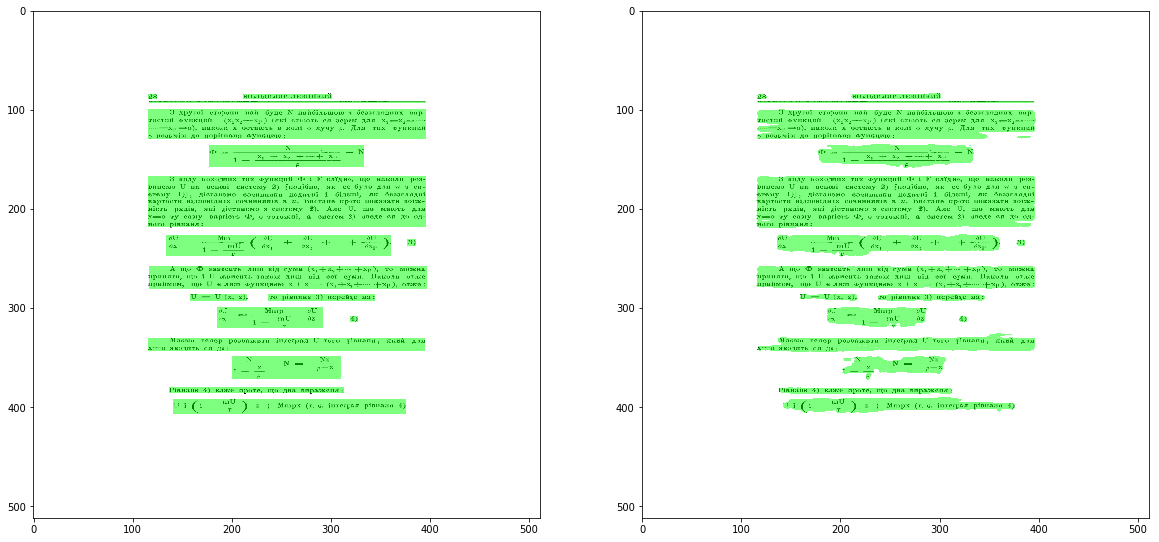

[0.00475419 0.00510451 0.00510742 ... 0.99991775 0.99991953 0.999926  ]


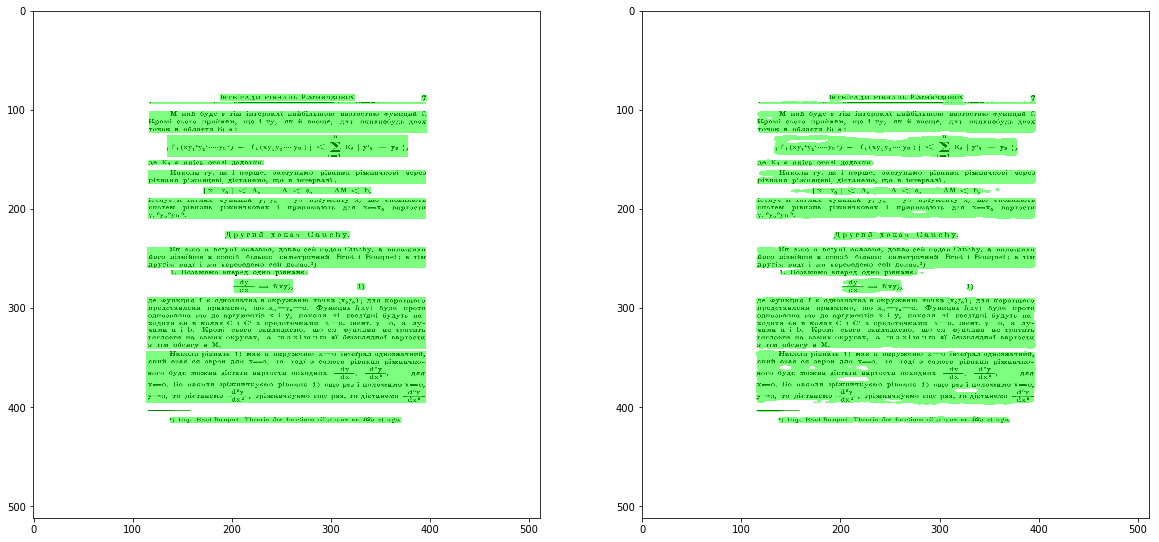

[0.00308281 0.00309197 0.00311365 ... 0.9999553  0.9999567  0.9999604 ]


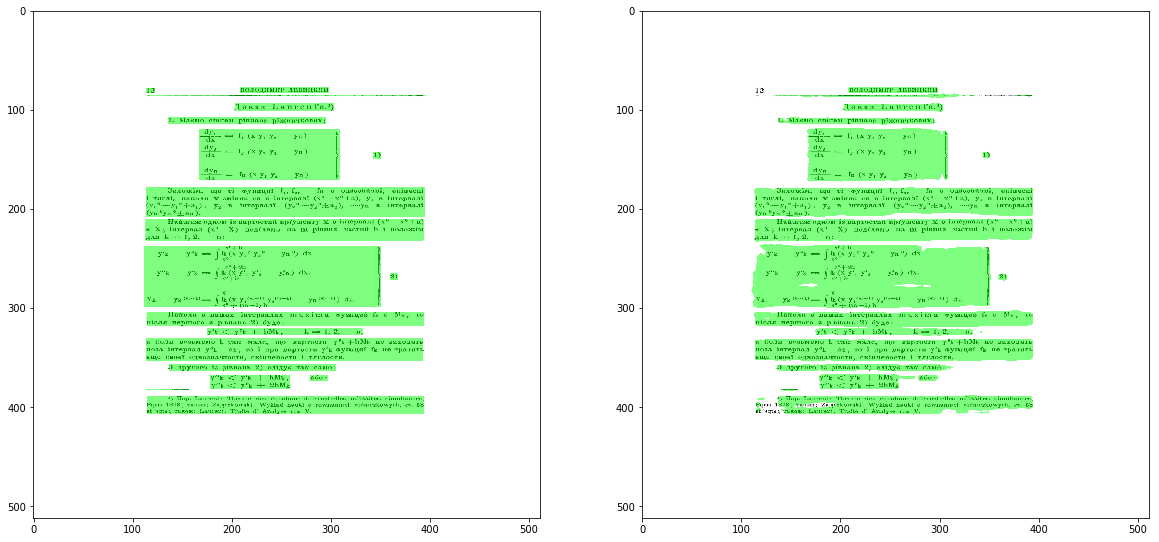

[0.00365696 0.00387171 0.00407033 ... 0.9999665  0.99997175 0.99997485]


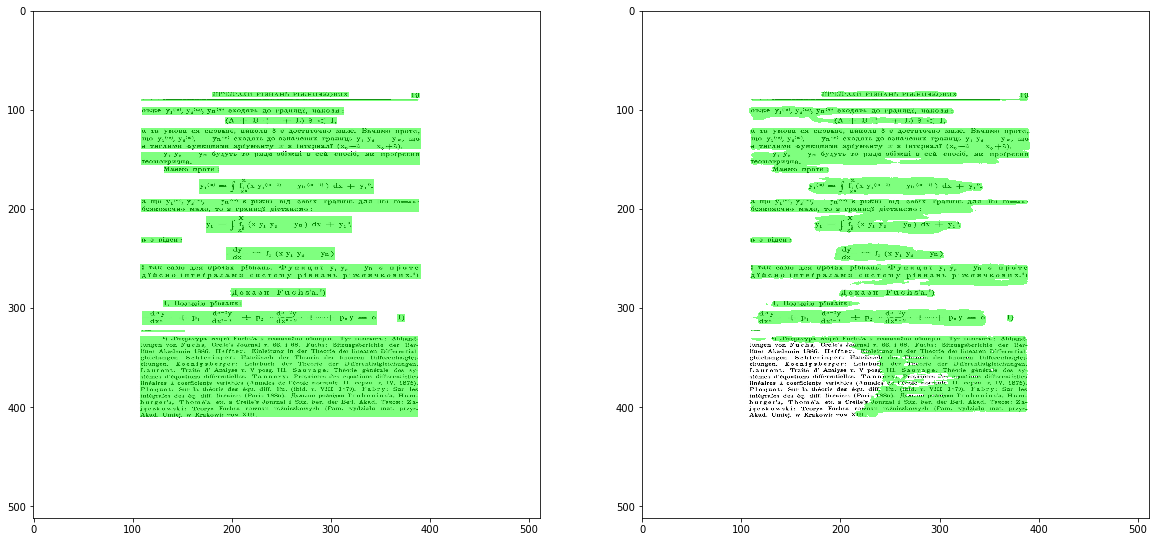

[0.00513932 0.00534343 0.00536298 ... 0.999944   0.9999443  0.99994826]


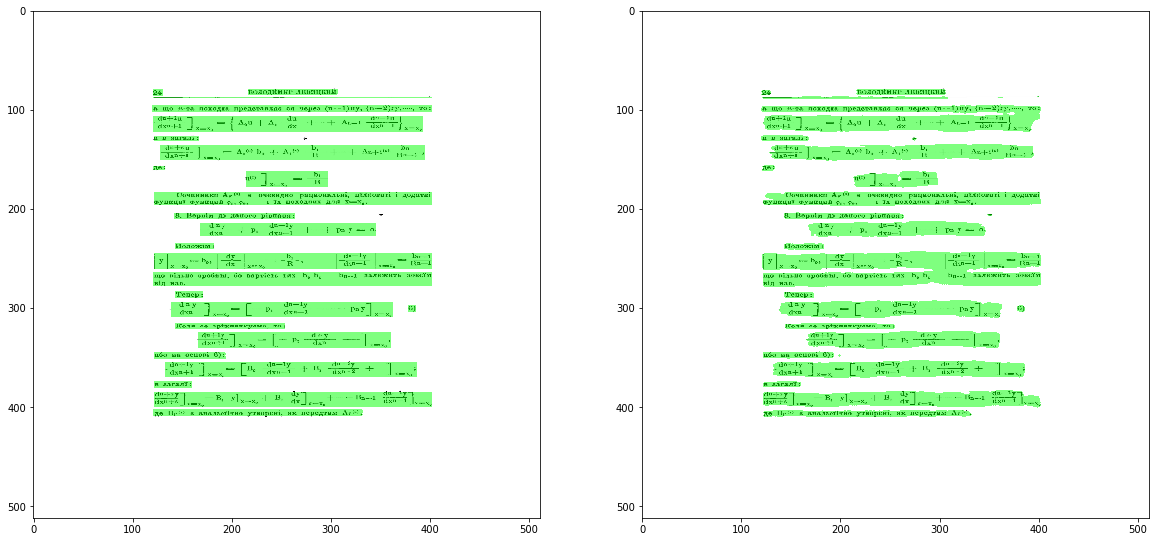

[0.00420206 0.00431711 0.00478802 ... 0.9999479  0.9999534  0.99995565]


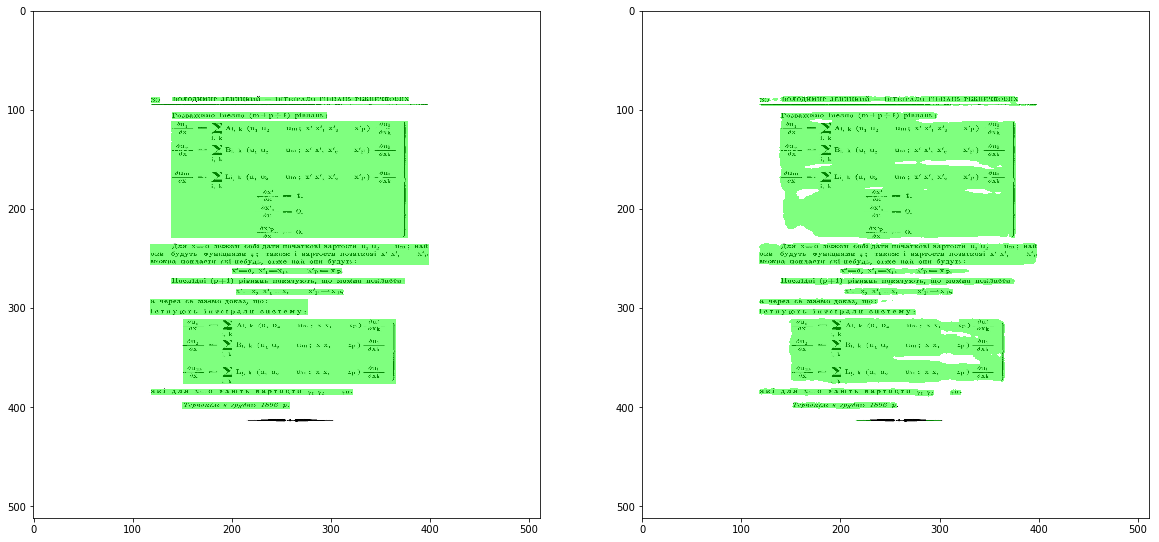

[0.00360842 0.00381318 0.00415238 ... 0.9999907  0.99999154 0.99999166]


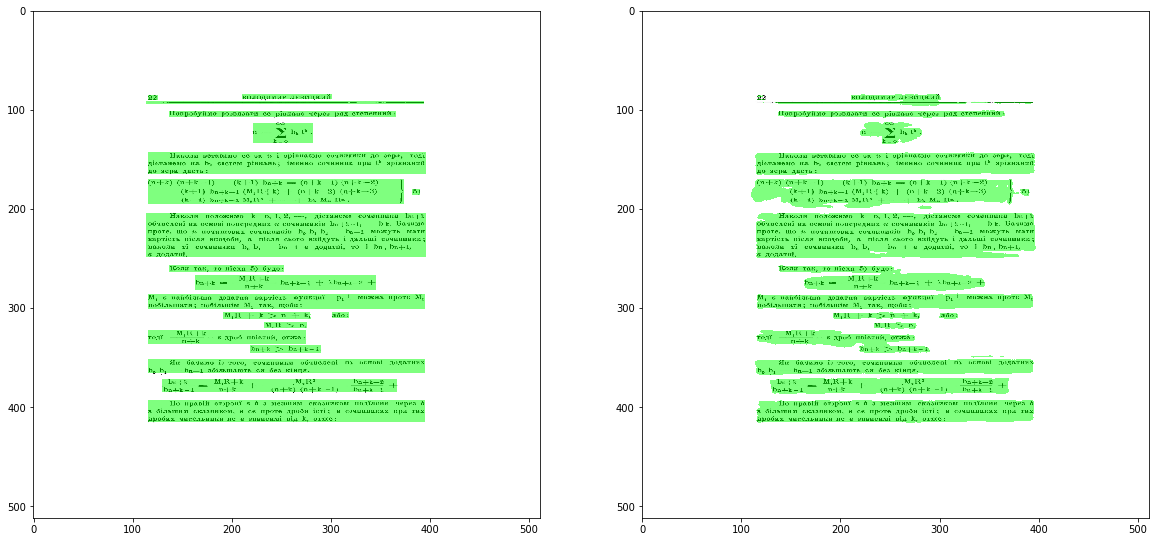

[0.0044355  0.00469723 0.00472825 ... 0.9999505  0.9999635  0.99996436]


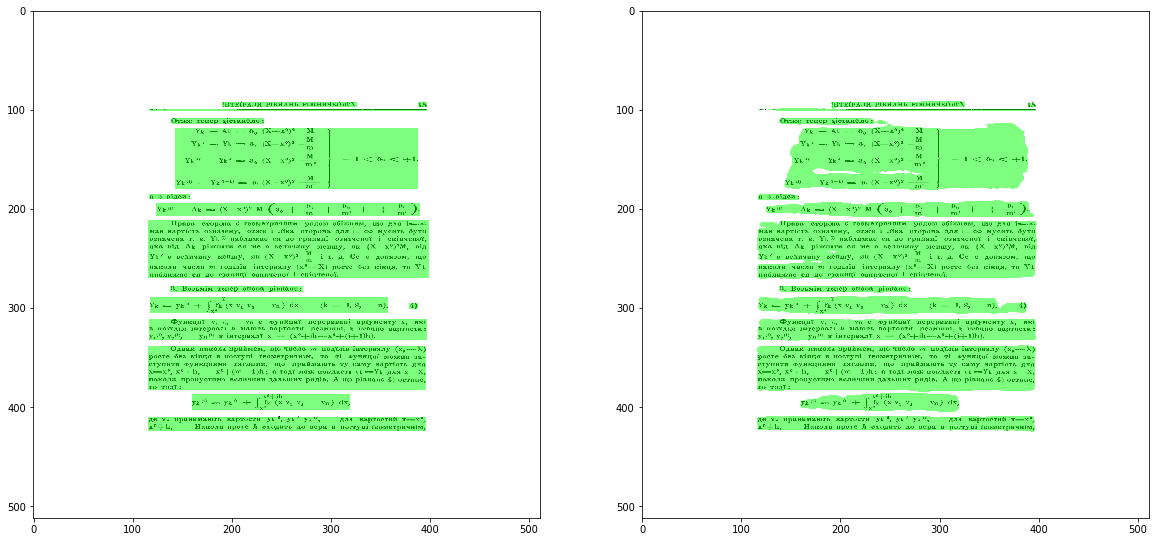

[0.00512055 0.00528607 0.00561701 ... 0.9999914  0.999992   0.9999927 ]


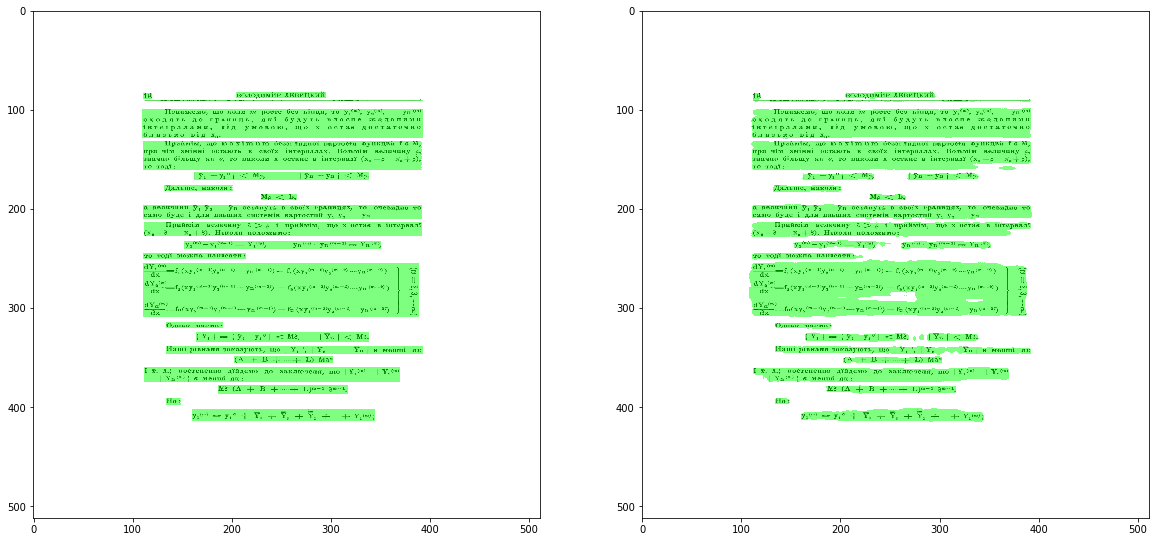

[0.00392175 0.0039508  0.00420374 ... 0.9999895  0.99999034 0.9999927 ]


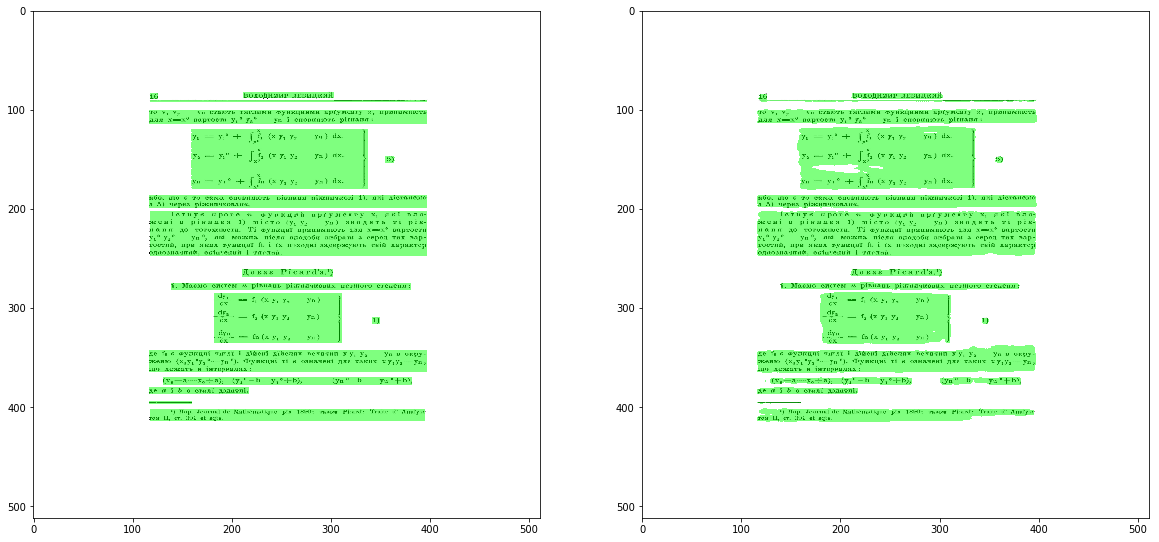

[0.00515904 0.00549217 0.00571024 ... 0.9999194  0.9999255  0.9999304 ]


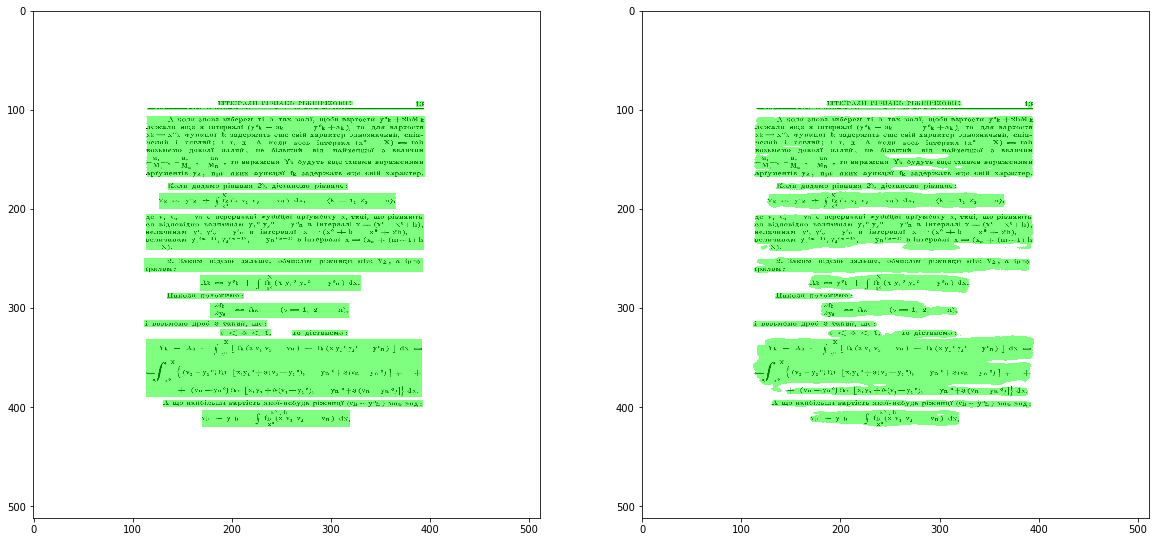

[0.00506869 0.00519494 0.00532265 ... 0.99998236 0.99998343 0.9999845 ]


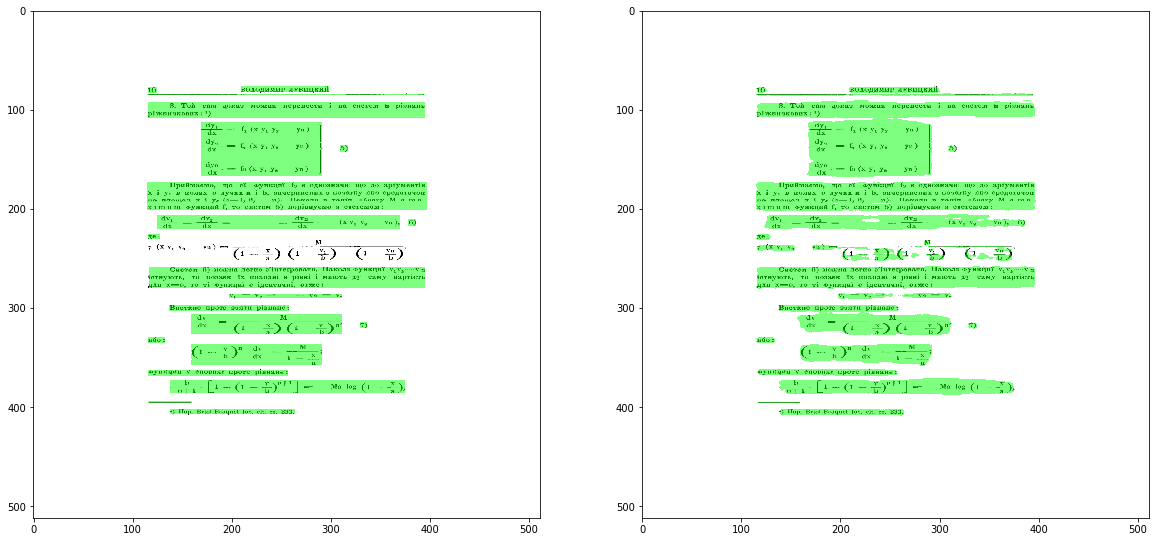

[0.00447787 0.00472712 0.00478346 ... 0.9999001  0.9999058  0.99990845]


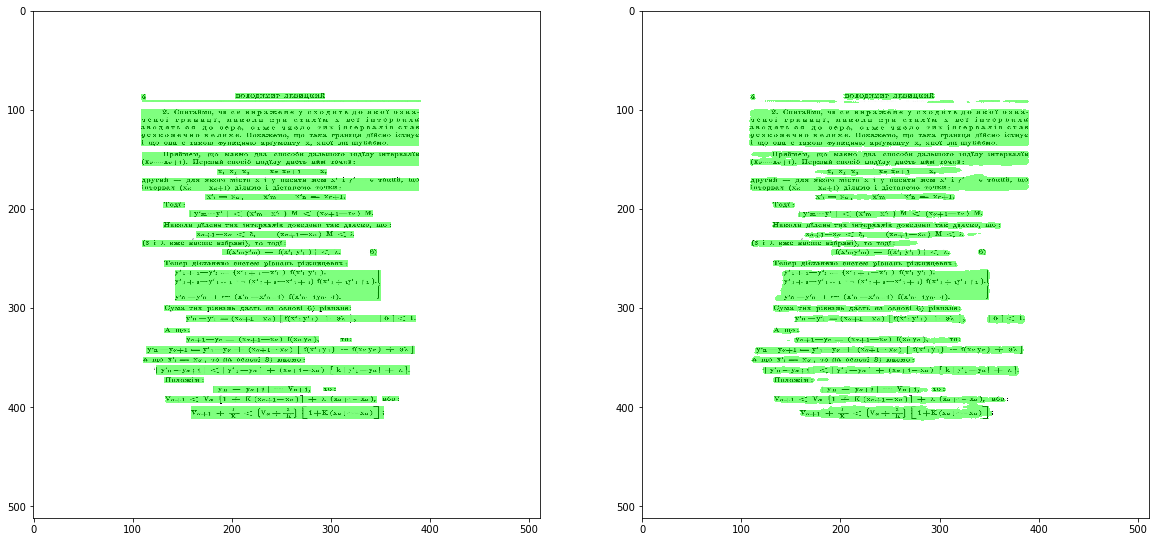

[0.00686071 0.00709641 0.00722233 ... 0.9999223  0.99992406 0.9999367 ]


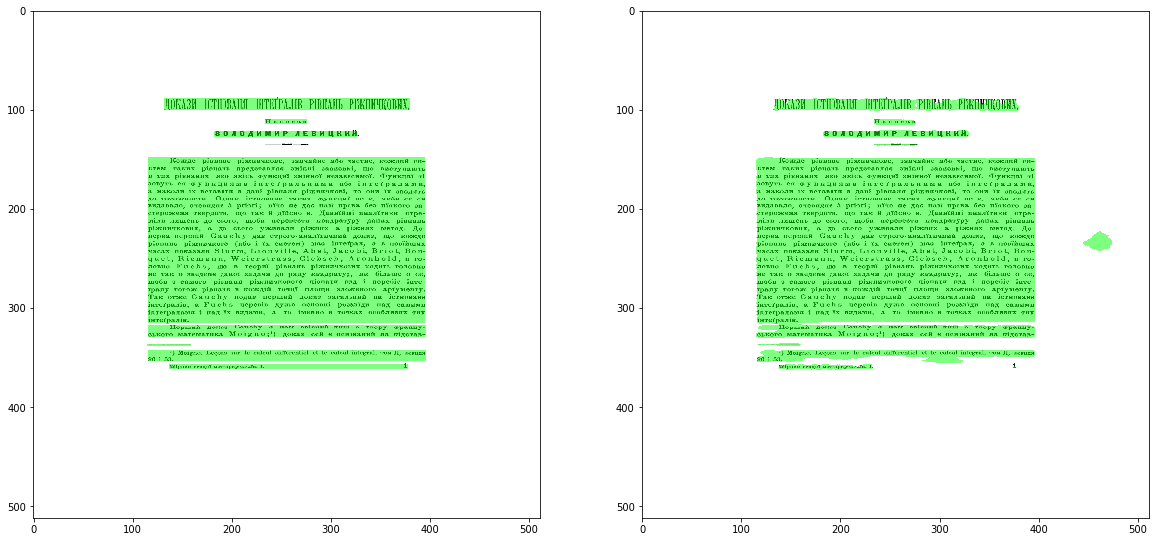

[0.00397125 0.00435944 0.00485718 ... 0.99990153 0.9999056  0.9999101 ]


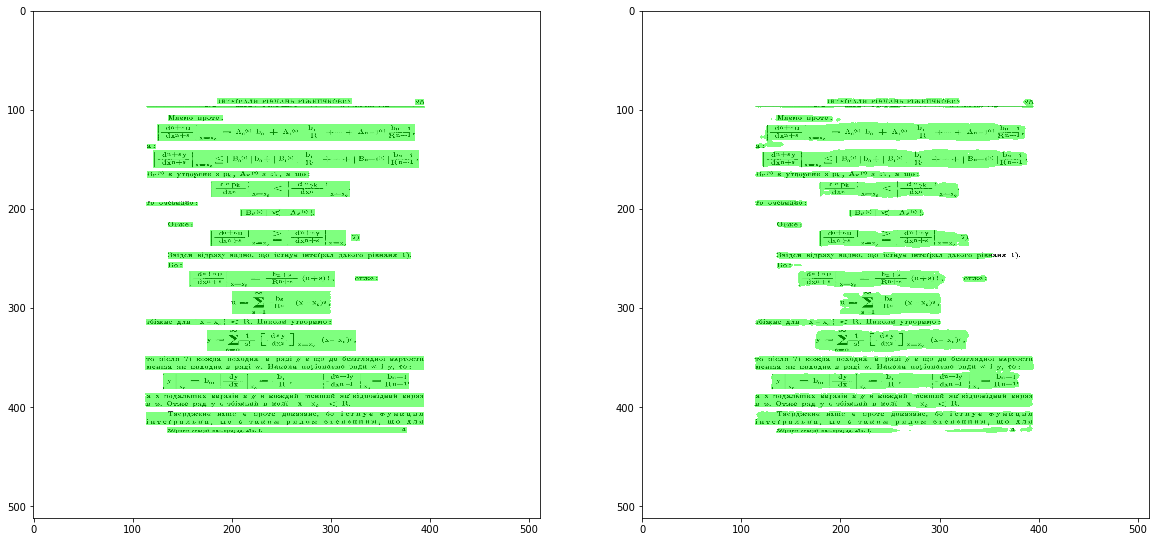

[0.00505359 0.00521066 0.00521109 ... 0.99997103 0.99997175 0.9999727 ]


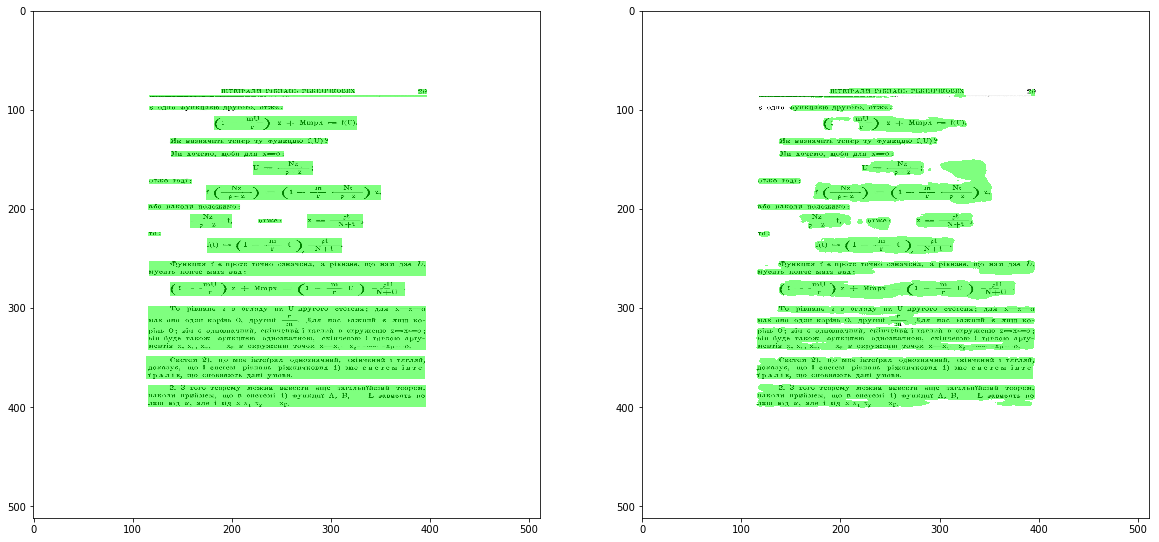

In [24]:
in_path = "data/supervisely/zbirnyk/tom_1/1120-2163-1-PB"
categories=("text", "maths", "separator")
files = os.listdir(os.path.join(in_path, ANNOTATION_FOLDER))
for i, file in enumerate(files):
    if i > 25:
        break
    file = os.path.join(in_path, ANNOTATION_FOLDER, file)
    image_object = parse_json(file)
    img = image_object.image
    grey = cv2.cvtColor(image_object.image, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(grey)

    for region in image_object.regions:
        if region.category in categories:
            mn = np.min(region.contour, axis=0)
            mx = np.max(region.contour, axis=0)
            block = grey[mn[1]:mx[1], mn[0]:mx[0]] / 255
            mask[mn[1]:mx[1], mn[0]:mx[0]] = 1
    grey = cv2.resize(grey, (512, 512))
    img = cv2.resize(img, (512, 512))
    mask = (cv2.resize(mask, (512, 512)) > 0)
    with torch.no_grad():
        pred_mask = (model(torch.Tensor(grey.astype(np.float) / 255.0).float().unsqueeze(0).unsqueeze(0)).sigmoid()\
            .squeeze(0).squeeze(0).numpy())
        print(np.unique(pred_mask))
        pred_mask = pred_mask > 0.5

    pred_img = img.copy()
    img[mask] = img[mask] / 2 + [0, 127.5, 0]
    pred_img[pred_mask] = pred_img[pred_mask] / 2 + [0, 127.5, 0]

    plt.figure(figsize=(20, 40))
    plt.subplot(121), plt.imshow(img)#, cmap="gray")
    plt.subplot(122), plt.imshow(pred_img)#, cmap="gray")
    plt.show()


In [28]:
img.shape

(3508, 2482, 3)